## FigS15: Changing inducer concentration for the inducible activator

Required packages:

In [1]:
# processing
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/figS15/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

And finally we read in and normalize the experimentally determined energy matrix for the CRP activator (Kinney et al, 2010) (https://www.pnas.org/doi/full/10.1073/pnas.1004290107). The original energy matrix reported in the paper contains energy terms in the unit of $kcal / mol$, here we convert them to $k_BT$ units.

In [5]:
crp_emat_raw = pd.read_table(fdir + 'energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy() * 1.62
crp_emat = tregs.simulate.fix_wt(crp_emat, crp_site).T

### Simple activation with induction

Firstly, we define the function `simact_pbound_with_inducer`, which calculates $p_{\mathrm{bound}}$ when the activator in the simple activation motif is made inducible. In addition, we define the helper function `get_pactive` which calculates the proportion of activators that are active.

In [6]:
def get_pactive(c, M_AL, M_AR, M_IL, M_IR, e_AI):
    """
    Calculate the probability that the activator is in an active state

    Parameters:
    ----------
    c : float
        Concentration of the inducer.
    M_AL : float
        Dissociation constant between the inducer and the left binding pocket of the active activator.
    M_AR : float
        Dissociation constant between the inducer and the right binding pocket of the active activator.
    M_IL : float
        Dissociation constant between the inducer and the left binding pocket of the inactive activator.
    M_IR : float
        Dissociation constant between the inducer and the right binding pocket of the inactive activator.
    e_AI : float
        Free energy difference between the active activator state and the inactive activator state.
    
    Returns:
    -------
    float
        The probability that the activator is in an active state.
    """
    z = np.zeros(8)
    z[0] = 1
    z[1] = c / M_AL
    z[2] = c / M_AR
    z[3] = z[1] * z[2]
    z[4] = np.exp(- 2 * e_AI)
    z[5] = z[4] * c / M_IL
    z[6] = z[4] * c / M_IR
    z[7] = z[4] * (c / M_IL) * (c / M_IR)

    return np.sum(z[:4]) / np.sum(z)


def simact_pbound_with_inducer(p_seq, a_seq, n_NS, n_p, n_a,
                               p_emat, a_emat,
                               ep_wt, eaa_wt, eai_wt,
                               c, M_AL, M_AR, M_IL, M_IR, e_int_A, e_int_I, e_AI):
    """
    Calculate the probability of RNAP being bound in the presence of an inducer.

    Parameters:
    ----------
    p_seq : str
        Sequence of the RNAP binding site.
    a_seq : str
        Sequence of the activator binding site.
    n_NS : float
        Scaling factor for non-specific binding.
    n_p : int
        Number of RNAP.
    n_a : int
        Number of activators.
    p_emat : array-like
        Energy matrix for RNAP.
    a_emat : array-like
        Energy matrix for activator.
    ep_wt : float
        Wild-type binding energy for RNAP.
    eaa_wt : float
        Wild-type binding energy for the active activator.
    eai_wt : float
        Wild-type binding energy for the inactive activator.
    c : float
        Concentration of the inducer.
    M_AL : float
        Dissociation constant between the inducer and the left binding pocket of the active activator.
    M_AR : float
        Dissociation constant between the inducer and the right binding pocket of the active activator.
    M_IL : float
        Dissociation constant between the inducer and the left binding pocket of the inactive activator.
    M_IR : float
        Dissociation constant between the inducer and the right binding pocket of the inactive activator.
    e_int_A : float
        Interaction energy between RNAP and the active activator.
    e_int_I : float
        Interaction energy between RNAP and the inactive activator.
    e_AI : float
        Free energy difference between the active activator state and the inactive activator state.

    Returns:
    -------
    float
        The probability of RNAP being bound.
    """

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_aa = tregs.simulate.get_weight(a_seq, a_emat, e_wt=eaa_wt)
    w_ai = tregs.simulate.get_weight(a_seq, a_emat, e_wt=eai_wt)
    pactive = get_pactive(c, M_AL, M_AR, M_IL, M_IR, e_AI)

    z = np.zeros(6)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = pactive * n_a / n_NS * w_aa
    z[3] = (1 - pactive) * n_a / n_NS * w_ai
    z[4] = z[2] * z[1] * np.exp(-e_int_A)
    z[5] = z[3] * z[1] * np.exp(-e_int_I)

    return (z[1] + z[4] + z[5]) / np.sum(z)

For each inducer concentration, we simulate 20 synthetic datasets in order to observe the average effects. To save computational time, we first generate 20 mutant libraries beforehand using the function `mutations_rand`.

In [7]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

We define the usual parameters needed for a simple activation thermodynamic model and the range of inducer concentrations. For each inducer concentration, we build synthetic datasets for each of the 20 pre-generated synthetic dataset and we keep track of the average mutual information at the activator binding site.

In [8]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
eaa_wt = -13
eai_wt = -1
e_int_A = -4
e_int_I = 0
e_AI = -2

M_AL = 3 * 10**(-6)
M_AR = 3 * 10**(-6)
M_IL = 10**(-7)
M_IR = 10**(-7)

signal = []
inducer_conc = []
for i in np.arange(-10, -2, 0.2):
    c = 10**i
    inducer_conc.append(c)

    tmp = []
    for i in range(len(mutant_bank)):
        df = tregs.simulate.sim(promoter, simact_pbound_with_inducer, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, eaa_wt, eai_wt,
                          c, M_AL, M_AR, M_IL, M_IR, e_int_A, e_int_I, e_AI],
                          preset_mutants=mutant_bank[i])

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        tmp.append(np.mean(footprint[(-70+115):(-52+116)]))
    signal.append(np.mean(tmp))

The curve is sigmoidal shaped, and we fit a sigmoidal curve to it.

In [9]:
def sigmoid(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

p0 = [-max(signal), min(signal), 1, 1]

norm_inducer_conc = np.asarray(inducer_conc)

popt, pcov = curve_fit(sigmoid, norm_inducer_conc, signal, p0, maxfev=10000)

Finally, we plot the average mutual information at the activator binding site against the normalized inducer concentration.

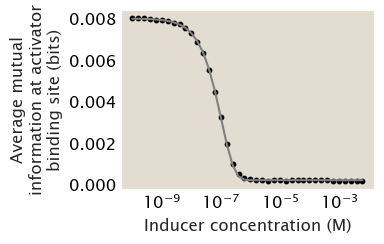

In [10]:
fig, ax = plt.subplots(figsize=(4, 2.6))
ax.scatter(inducer_conc, signal, color='k', s=10)
ax.plot(inducer_conc, sigmoid(norm_inducer_conc, *popt), color='grey')
ax.set_xscale('log')
ax.set_xlabel('Inducer concentration (M)')
ax.set_ylabel('Average mutual\ninformation at activator\nbinding site (bits)')
plt.tight_layout()
plt.savefig(out_fdir + 'inducer_activator.pdf', bbox_inches='tight')

### 1.2 Example information footprint at high and low inducer concentrations

First, we simulate an information footprint at the inducer concentration $10^{-9}\, M$.

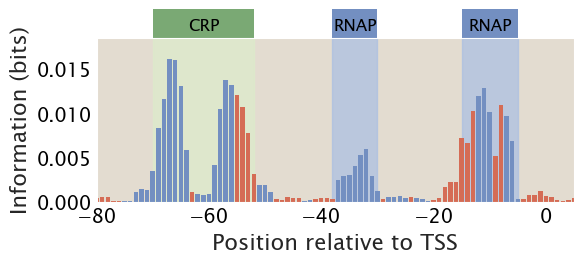

In [11]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
eaa_wt = -13
eai_wt = -1
e_int_A = -4
e_int_I = 0
e_AI = -2

M_AL = 3 * 10**(-6)
M_AR = 3 * 10**(-6)
M_IL = 10**(-7)
M_IR = 10**(-7)

c = 10**(-9)
df = tregs.simulate.sim(promoter, simact_pbound_with_inducer, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, eaa_wt, eai_wt,
                          c, M_AL, M_AR, M_IL, M_IR, e_int_A, e_int_I, e_AI])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=6,
                               outfile=out_fdir + 'inducer_activator_fp1.pdf')

We also simulate an information footprint at the inducer concentration $10^{-3}\, M$.

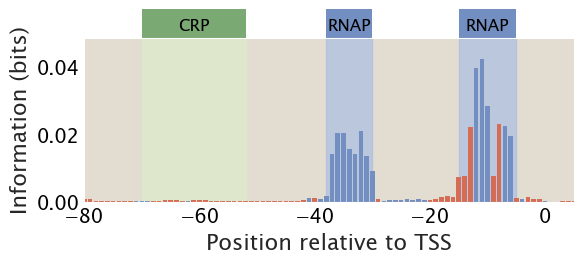

In [12]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
eaa_wt = -13
eai_wt = -1
e_int_A = -4
e_int_I = 0
e_AI = -2

M_AL = 3 * 10**(-6)
M_AR = 3 * 10**(-6)
M_IL = 10**(-7)
M_IR = 10**(-7)

c = 10**(-3)
df = tregs.simulate.sim(promoter, simact_pbound_with_inducer, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, eaa_wt, eai_wt,
                          c, M_AL, M_AR, M_IL, M_IR, e_int_A, e_int_I, e_AI])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=6,
                               outfile=out_fdir + 'inducer_activator_fp2.pdf')